In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import os
import tqdm
train_df = pd.read_csv('C:/Users/Hg/wells_system/w_system/toxic_pattern/model/image_train/_annotations.csv')
test_df = pd.read_csv('C:/Users/Hg/wells_system/w_system/toxic_pattern/model/image_test/_annotations.csv')
val_df = pd.read_csv('C:/Users/Hg/wells_system/w_system/toxic_pattern/model/image_validation/_annotations.csv')
image_train_dir = 'C:/Users/Hg/wells_system/w_system/toxic_pattern/model/image_train'
image_test_dir = 'C:/Users/Hg/wells_system/w_system/toxic_pattern/model/image_test'
image_validation_dir = 'C:/Users/Hg/wells_system/w_system/toxic_pattern/model/image_validation'
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,d630b47f-istockphoto-474582360-612x612_jpg.rf....,640,640,guns,40,182,425,469
1,b0f06489-_3rYf85T_jpg.rf.3731bd52045301cfbb58c...,640,640,guns,218,280,376,575
2,-_jpg.rf.2d28603d755d9d3f96968791ef56b590.jpg,640,640,nazi,301,332,428,614
3,-_jpg.rf.2d28603d755d9d3f96968791ef56b590.jpg,640,640,nazi,578,317,640,397
4,-_jpg.rf.2d28603d755d9d3f96968791ef56b590.jpg,640,640,nazi,107,304,211,377


In [6]:
def load_image_data(ids,df):
    image_data = []
    for img_id in tqdm.tqdm(ids):
        match df:
            case 'train':
                img_path = os.path.join(image_train_dir, img_id)
            case 'val':
                img_path = os.path.join(image_validation_dir, img_id)
            case 'test':
                img_path = os.path.join(image_test_dir, img_id)

        im = Image.open(img_path)
        im = im.resize((200, 200))
        im = np.expand_dims(im, axis=-1)
        image_data.append(im)
    return image_data

In [7]:
train_images = load_image_data(train_df['filename'], 'train')
val_images = load_image_data(val_df['filename'], 'val')
test_images = load_image_data(test_df['filename'], 'test')
#train and test data are turned into arrays
train_image_data = np.array(train_images).astype(np.float16)
val_image_data = np.array(val_images).astype(np.float16)
test_image_data = np.array(test_images).astype(np.float16)

100%|██████████| 672/672 [00:06<00:00, 100.07it/s]


In [8]:
rating_dummy = pd.get_dummies(train_df['class'])

train_df['class'] = train_df['class'].apply(lambda p: p.replace(',', ''))

train_df['nazi class'] = rating_dummy['nazi']
train_df['person class'] = rating_dummy['person']
train_df['guns class'] = rating_dummy['guns']
val_df['nazi class'] = rating_dummy['nazi']
val_df['person class'] = rating_dummy['person']
val_df['guns class'] = rating_dummy['guns']

train_df.drop(['class'], axis=1, inplace=True)
val_df.drop(['class'], axis=1, inplace=True)

valid_cols = ['nazi class', 'person class', 'guns class']

train_labels = train_df[valid_cols]
valid_labels = val_df[valid_cols]
#train_labels = np.clip(train_labels, 0, 100)
train_labels

,nazi class,person class,guns class
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,0
...,...,...,...
5285,0,0,0
5286,0,1,0
5287,0,1,0
5288,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split

image_train, image_val, label_train, label_val = train_test_split(train_image_data, train_labels, test_size=.1, random_state=1)

In [9]:
print(train_image_data.shape)
print(val_image_data.shape)
print(train_labels.shape)
print(valid_labels.shape)

(5290, 200, 200, 3, 1)
(672, 200, 200, 3, 1)
(5290, 3)
(672, 3)


In [10]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
# Concatenate helps to plug different branches of a neural network together
# Here are the 2 separate inputs to our model which will be called image input
# Maxpooling2D is how we combine layers together
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



#Image Model
image_input = Input(shape=(200,200,3,))
#speedInput = Input(shape=(1,)) won't need this until later

output_of_layer1 = Conv2D(64, (3, 3), activation="relu")(image_input)#this function is a higher order function
output_of_layer2 = MaxPooling2D((3,3))(output_of_layer1)
output_of_layer3 = Conv2D(32, (3, 3), activation="relu")(output_of_layer2)#Conv2D params(layers,[], activation)
output_of_layer4 = Flatten()(output_of_layer3)
output_of_layer5= Dense(32, activation="relu")(output_of_layer4)

image_model = Model(inputs=image_input, outputs=output_of_layer5)

final_model = Dense(4, activation="relu")(output_of_layer5)
final_model = Dense(1, activation="relu")(final_model)#should never be negative so it can be a relu instead of linear, but to do so causes overfitting

model = Model(inputs=[image_model.input], outputs=final_model)

In [11]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.003))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 32)                4194336   
                                                           

In [13]:
history = model.fit(
    x=train_image_data, 
    y=train_labels, 
    validation_data=(val_image_data, valid_labels), 
    epochs=20)

Epoch 1/20
166/166 [==============================] - 95s 565ms/step - loss: 0.6008 - val_loss: 0.2381
Epoch 2/20
166/166 [==============================] - 101s 610ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 3/20
166/166 [==============================] - 110s 660ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 4/20
166/166 [==============================] - 106s 636ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 5/20
166/166 [==============================] - 108s 649ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 6/20
166/166 [==============================] - 101s 611ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 7/20
166/166 [==============================] - 101s 610ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 8/20
166/166 [==============================] - 101s 611ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 9/20
166/166 [==============================] - 102s 612ms/step - loss: 0.2467 - val_loss: 0.2381
Epoch 10/20
166/166 [==============================] - 101s 608ms

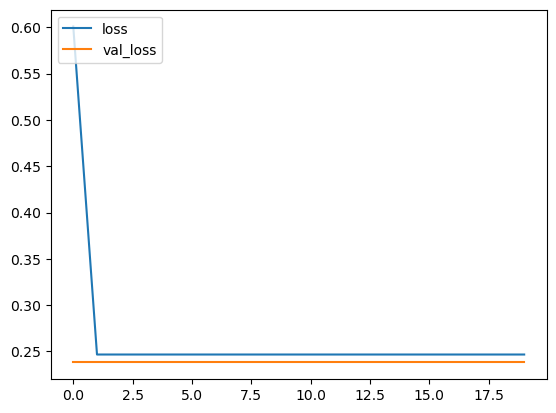

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left') 

In [15]:
test_df['nazi class'] = model.predict(test_image_data)

4/4 [==============================] - 1s 98ms/step


In [16]:
test_df['nazi class']

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
95    0.0
96    0.0
97    0.0
98    0.0
99    0.0
Name: nazi class, Length: 100, dtype: float32

(array([19.,  0.,  0.,  0.,  0., 49.,  0.,  0.,  0., 32.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

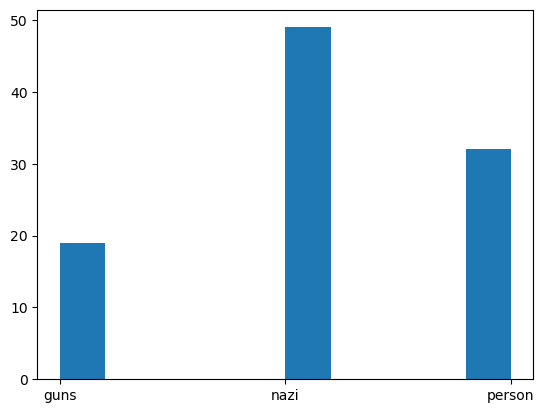

In [18]:
plt.hist(test_df['class'])

In [19]:
test_df[['filename', 'class']].to_csv('submission.csv', index=False)